Start from design models selected by AF2, nstruct 5

In [1]:
# %load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers
running on node: dig205


In [6]:
import os, stat

ala_pen = 2
met_pen = 1
np_pen = 3

nstruct = 5
def create_tasks(selected):
    with open(selected, "r") as f:
        for i, line in enumerate(f):
            tasks = {"-s": line.rstrip()}
            tasks["-ala_pen"] = ala_pen
            tasks["-met_pen"] = met_pen
            tasks["-np_pen"] = np_pen
            yield tasks

selected = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/04_alphafold_one_state/selected_design.list"

msd_py = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_1/msd.py"

jid = "{SLURM_JOB_ID%;*}"
sid = "{SLURM_ARRAY_TASK_ID}p"

slurm_dir = os.path.join(os.getcwd(), '05_two_state/slurm_logs')

tasklist = f"05_two_state/run_1/05_msd_tasks.cmds"
run_sh = """#!/usr/bin/env bash \n#SBATCH -J 05_two_state \n#SBATCH -e {slurm_dir}/05_two_state-%J.err \n#SBATCH -o {slurm_dir}/05_two_state-%J.out \n#SBATCH -p {queue} \n#SBATCH --mem=12G \n
source activate /projects/crispy_shifty/envs/crispy\nJOB_ID=${jid} \nCMD=$(sed -n "${sid}" {tasklist}) \necho "${c}" | bash""".format(
    slurm_dir=slurm_dir, queue='backfill', jid=jid, sid=sid, tasklist=tasklist, c="{CMD}"
)
shell = f"05_two_state/run_1/05_msd.sh"
with open(shell, "w+") as f:
    print(run_sh, file=f)
st = os.stat(shell)
os.chmod(shell, st.st_mode | stat.S_IEXEC)
with open(tasklist, "w+") as f:
    n = 0
    for _ in range(nstruct):
        for tasks in create_tasks(selected):
            tasks["-subfolder"] = f'{n // 1000:04d}'
            n += 1
            args_ = " ".join([" ".join([k, str(v)]) for k, v in tasks.items()])
            cmd = f"{msd_py} {args_}"
            print(cmd, file=f)

# Let's go
print("Run the following commands")
print(f"sbatch -a 1-$(cat 05_two_state/run_1/05_msd_tasks.cmds | wc -l) 05_two_state/run_1/05_msd.sh")

Run the following commands
sbatch -a 1-$(cat 05_two_state/run_1/05_msd_tasks.cmds | wc -l) 05_two_state/run_1/05_msd.sh


In [2]:
# %%time

# retrieve the JSONs containing scores

import json

output_paths = glob("05_two_state/run_1/decoys/*/*.json")

scores = {}
errors = []

for test in tqdm(output_paths):
    key = test.replace("json", "pdb")
    try:
        with open(test, "r") as f:
            values = json.load(f)
        scores[key] = values
    except json.JSONDecodeError:
        errors.append(test)

100%|██████████| 2457/2457 [00:04<00:00, 516.92it/s]


In [3]:
len(errors)

0

In [4]:
scores_df = pd.DataFrame(scores)
scores_df = scores_df.T
output_path = "05_two_state/run_1"
output_file = os.path.join(output_path, "scores.json")
scores_df.to_json(output_file)

In [2]:
output_path = "05_two_state/run_1"
output_file = os.path.join(output_path, "scores.json")
scores_df = pd.read_json(output_file)
scores_df

,abego_str_A,abego_str_B,bb_clash,bb_clash_A,bb_clash_B,closure_type_A,closure_type_B,cms_ac_bn,cms_dhr,cms_dhr_ac,...,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,wnm_hlx_X,wnm_hlx_Y,remodel_after_loop_A,remodel_after_loop_B,remodel_before_loop_A,remodel_before_loop_B
05_two_state/run_1/decoys/0000/afc1931341877e4c7701992f09a80a294d0e6feee6f301c8.pdb,XAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAABAABA...,XAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAABAABA...,165.239746,49.930092,49.930092,loop_match,loop_match,-1.0,422.947693,542.850159,...,0.319367,0.638169,0.293630,0.805718,0.114832,0.143157,NaN,NaN,NaN,NaN
05_two_state/run_1/decoys/0000/2ea25af812800917e6e8842966b7fcce6782bd8aef116e53.pdb,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,101.942139,50.960457,50.972782,loop_remodel,loop_remodel,-1.0,368.311981,561.131531,...,0.330894,0.733133,0.298440,0.940658,0.108310,0.234275,1.0,3.0,3.0,1.0
05_two_state/run_1/decoys/0000/53a6653f5671821fc4868eaf9f25502eb5cb2dad84c44db3.pdb,XAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAAGBAA...,XAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAAGBAA...,125.534286,61.185627,61.186043,loop_match,loop_match,-1.0,375.868042,536.044495,...,0.244507,0.950320,0.223354,0.546362,0.106703,0.140129,NaN,NaN,NaN,NaN
05_two_state/run_1/decoys/0000/89cd2ba733bf71e1aef9389fd59efe92958f8b6da8f71c35.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAA...,757.124695,54.325855,54.604378,loop_remodel,loop_match,-1.0,445.277283,606.605774,...,0.200223,0.954342,0.236187,0.843566,0.104222,0.154118,1.0,NaN,2.0,NaN
05_two_state/run_1/decoys/0000/64c4e234e47cbdaffb9bade0544e62db6849930185e76447.pdb,XAAAAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAAAAAAAAB...,XAAAAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAAAAAAAAB...,1305.072632,52.802925,53.006519,loop_match,loop_match,-1.0,340.585876,833.158875,...,0.313884,0.957151,0.279251,1.140534,0.118164,0.134980,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
05_two_state/run_1/decoys/0002/3e0758fd8ce1e93edf9c1f889d76a42b411785894592b780.pdb,XAAAAAAAAAAAAAAAAAAAAAAABAABAAAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAABAABAAAAAAAAAAAAAAAAAA...,118.126617,58.995125,58.995125,loop_remodel,loop_remodel,-1.0,504.111633,821.365295,...,0.325567,1.623495,0.342259,0.644122,0.182455,0.245651,3.0,3.0,2.0,3.0
05_two_state/run_1/decoys/0002/028cb7e559e894a0f7d8399beeae0ceb97b4167b9cdbc6c5.pdb,XBAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAA...,XBAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAA...,354.687714,74.775955,74.775955,loop_match,loop_match,-1.0,465.294678,800.473999,...,0.326338,0.864423,0.335971,0.772024,0.131723,0.105849,NaN,NaN,NaN,NaN
05_two_state/run_1/decoys/0002/aa126c9f34cd8199ae61bcca7c66f5001b0f6e5dcb2ce841.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAA...,157.232971,64.283478,64.283478,loop_match,loop_match,-1.0,584.256836,648.372437,...,0.313695,0.810160,0.309202,0.646933,0.108096,0.153914,NaN,NaN,NaN,NaN
05_two_state/run_1/decoys/0002/52212cffc6dafac8779fb80c704466c7db1c13b2919fbd84.pdb,XAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAABBBAAA...,XAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAABBBAAA...,268.150024,52.911160,53.510536,loop_match,loop_match,-1.0,293.758820,435.267731,...,0.284217,0.409734,0.311562,0.346377,0.090384,0.133031,NaN,NaN,NaN,NaN


In [6]:
scores_df['Y-X'] = scores_df['total_score_Y'] - scores_df['total_score_X']
scores_df['A_Y-X'] = scores_df['total_score_A_Y'] - scores_df['total_score_A_X']
scores_df['B_Y-X'] = scores_df['total_score_B_Y'] - scores_df['total_score_B_X']

In [9]:
def histplot_df(df, hue_col=None, hue_order=None):
    sns.set(
        context="talk",
        # font_scale=1,  # make the font larger; default is pretty small
        style="ticks",  # make the background white with black lines
        palette="colorblind",  # a color palette that is colorblind friendly!
    )

    fig, axs = plt.subplots(5, 6, figsize=(24,20))

    cols = [
        "score_per_res_X",
        "score_per_res_Y",
        "Y-X",
        "A_Y-X",
        "B_Y-X",
        "ddg_Y",
        "cms_Y",
        "sasa_Y",
        "sc_int_Y",
        "sc_X",
        "sc_Y",
        "ibuns_Y",
        "vbuns_X",
        "vbuns_Y",
        "sap_X",
        "sap_Y",
        "sap_A_X",
        "sap_B_X",
        "wnm_hlx_X",
        "wnm_hlx_Y",
        "wnm_all_A_X",
        "wnm_all_A_Y",
        "wnm_all_B_X",
        "wnm_all_B_Y",
        "mismatch_probability_X",
        "mismatch_probability_Y",
        "geometry_X",
        "geometry_Y",
        "geometry_loop_X",
        "geometry_loop_Y",
    #     "parent",
    ]

    for ax, col in zip(axs.flatten(),cols):
        sns.histplot(
            data=df,
            x=col,
            ax=ax,
            hue=hue_col,
            hue_order=hue_order,
            legend=None
        )

    plt.tight_layout()

In [21]:
def copy_designs(df, out_dir):
    import os
    import shutil
    # Copy designs to a folder
    os.makedirs(out_dir, exist_ok=True)
    
    keys = ['parent',
            'Y-X',
            'sap_A_X',
            'sap_B_X',
            'sap_Y',
            'sc_int_Y',
            'wnm_hlx_X',
            'wnm_hlx_Y',
            'wnm_all_A_X',
            'wnm_all_B_X',
            'wnm_all_A_Y',
            'wnm_all_B_Y',
           ]

    for index, row in df.iterrows():
        filename = out_dir
        for key in keys:
            val = row[key]
            if type(val) != str:
                val = f'_{val:.03f}'
            filename += val
        filename += '.pdb'
    #     print(filename)
        shutil.copy(index, filename)

In [11]:
def print_scores(df):
    cols = [
        "score_per_res_X",
        "score_per_res_Y",
        "Y-X",
        "A_Y-X",
        "B_Y-X",
        "ddg_Y",
        "cms_Y",
        "sasa_Y",
        "sc_int_Y",
        "sc_X",
        "sc_Y",
        "ibuns_Y",
        "vbuns_X",
        "vbuns_Y",
        "sap_X",
        "sap_Y",
        "sap_A_X",
        "sap_B_X",
        "wnm_hlx_X",
        "wnm_hlx_Y",
        "wnm_all_A_X",
        "wnm_all_A_Y",
        "wnm_all_B_X",
        "wnm_all_B_Y",
        "mismatch_probability_X",
        "mismatch_probability_Y",
        "geometry_X",
        "geometry_Y",
        "geometry_loop_X",
        "geometry_loop_Y",
        "parent",
    ]
    print_df = df[cols]

    from IPython.display import display
    with pd.option_context(
        # 'display.max_rows', 5,
        'display.max_columns', None,
        # 'display.width', 1000,
        # 'display.precision', 3,
        # 'display.colheader_justify', 'left'
    ):
        display(print_df)

In [3]:
def filter_df(df, cutoffs):
    filtered_df = df

    for score_term, cutoff, greaterthan in cutoffs:
        if greaterthan:
            filtered_df = filtered_df[filtered_df[score_term] > cutoff]
        else:
            filtered_df = filtered_df[filtered_df[score_term] < cutoff]

    print(len(filtered_df))
    
    return filtered_df

def filter_df_delta(df, parent_df, delta_cutoffs):
    filtered_df = df

    for score_term, parent_term, cutoff, greaterthan in delta_cutoffs:
        filtered_series = filtered_df[score_term]
        parent_scores = parent_df.loc[filtered_df['parent'], parent_term]
        parent_scores.index = filtered_series.index
        # print(filtered_series)
        # print(parent_scores)
        # print(parent_scores - filtered_series < cutoff)
        if greaterthan:
            filtered_df = filtered_df[filtered_series - parent_scores > -cutoff]
        else:
            filtered_df = filtered_df[filtered_series - parent_scores < cutoff]
    
    print(len(filtered_df))
    
    return filtered_df

In [13]:
def get_parents(df):
    parents = []
    for key, row in df.iterrows():
        parent = row['parent']
        if parent not in parents:
            parents.append(parent)
    print(len(parents))
    return parents

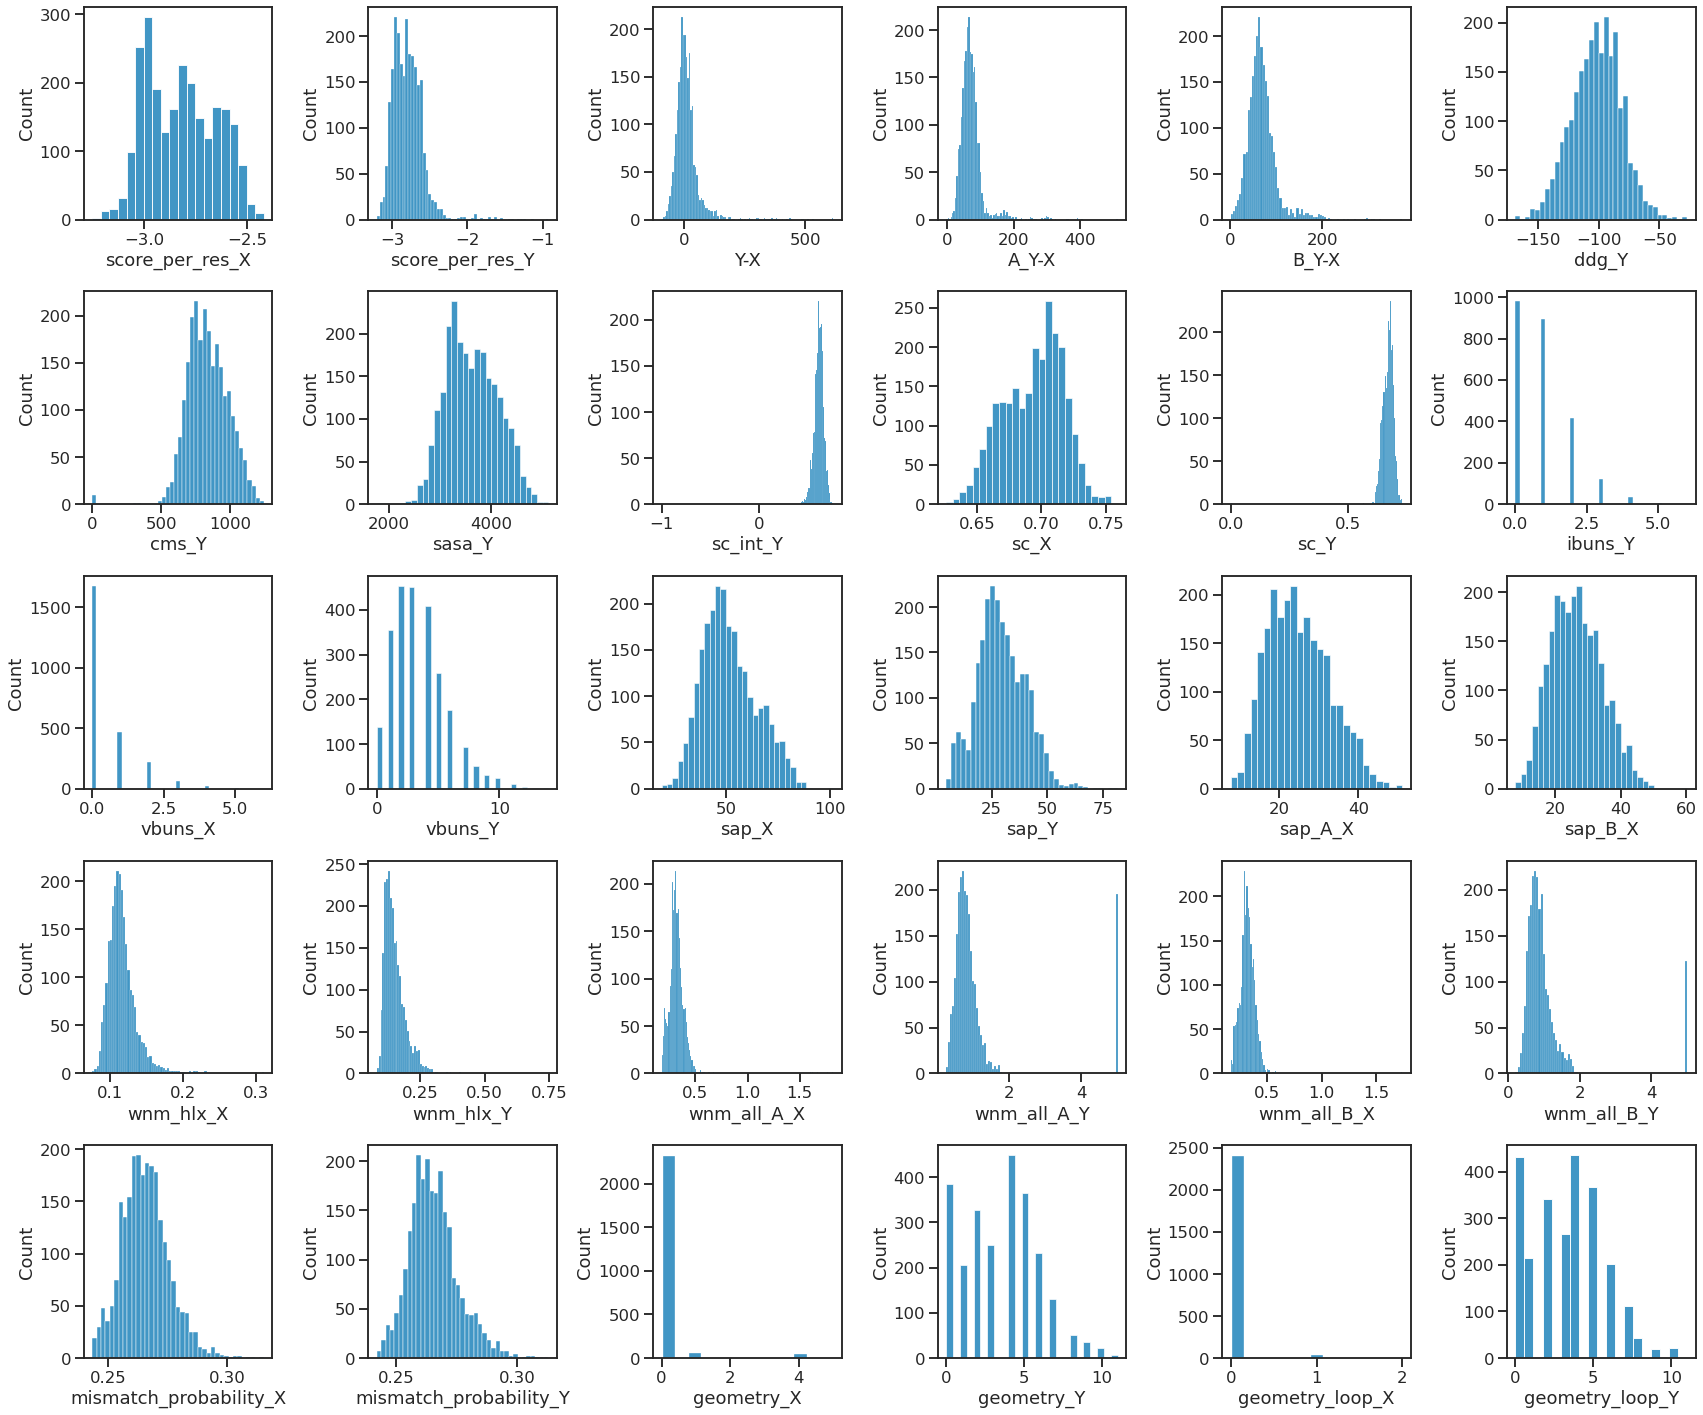

In [14]:
histplot_df(scores_df)

In [15]:
print(get_parents(scores_df))

59
['X22_3_16_4_ct4_fa', 'X20_3_18_2_ct13_fe', 'X19_3_18_4_ct4_fd', 'X26_3_20_2_ct1_fe', 'X18_4_23_4_ct3_ff', 'X28_2_25_2_ct2_fb', 'DHR79', 'TH_DHR_T7', 'X16_3_18_4_ct6_fe', 'hDHR79_5CWP', 'hDHR64_5CWM', 'TH_DHR_T5', 'X24_2_24_2_ct18_fg', 'X26_3_23_4_ct1_fd', 'hDHR71_5CWN', 'X26_3_26_4_ct2_fe', 'X26_3_27_4_ct2_fe', 'X23_2_15_3_ct5_fe', 'X22_4_20_3_ct0_ff', 'X19_4_19_4_ct5_fa', 'DHR71', 'X27_3_19_4_ct3_fe', 'X19_3_17_2_ct9_fe', 'DHR82', 'X27_2_27_2_ct5_fg', 'X16_3_19_3_ct33_fc', 'X24_4_24_3_ct3_fc', 'X17_4_20_3_ct10_fb', 'DHR26_nocys', 'X20_3_18_2_ct6_fa', 'X24_2_24_2_ct5_ff', 'X19_3_17_2_ct28_fe', 'X21_4_23_4_ct0_fg', 'X23_3_20_3_ct7_fc', 'X23_4_26_3_ct8_fc', 'X16_3_19_3_ct0_fd', 'X16_4_15_3_ct0_fc', 'X17_3_21_2_ct0_fd', 'X24_2_23_4_ct3_fd', 'DHR62', 'X19_4_18_2_ct6_fg', 'X18_4_22_4_ct0_ff', 'X19_3_19_3_ct11_fc', 'X19_3_17_2_ct6_fc', 'X26_3_24_2_ct12_fe', 'X23_4_25_4_ct0_fa', 'X16_4_16_2_ct7_fe', 'DHR39', 'hDHR53_5CWK', 'X20_3_18_2_ct3_fa', 'X22_4_23_3_ct6_fa', 'X17_4_20_3_ct4_fa', 'X1

2418


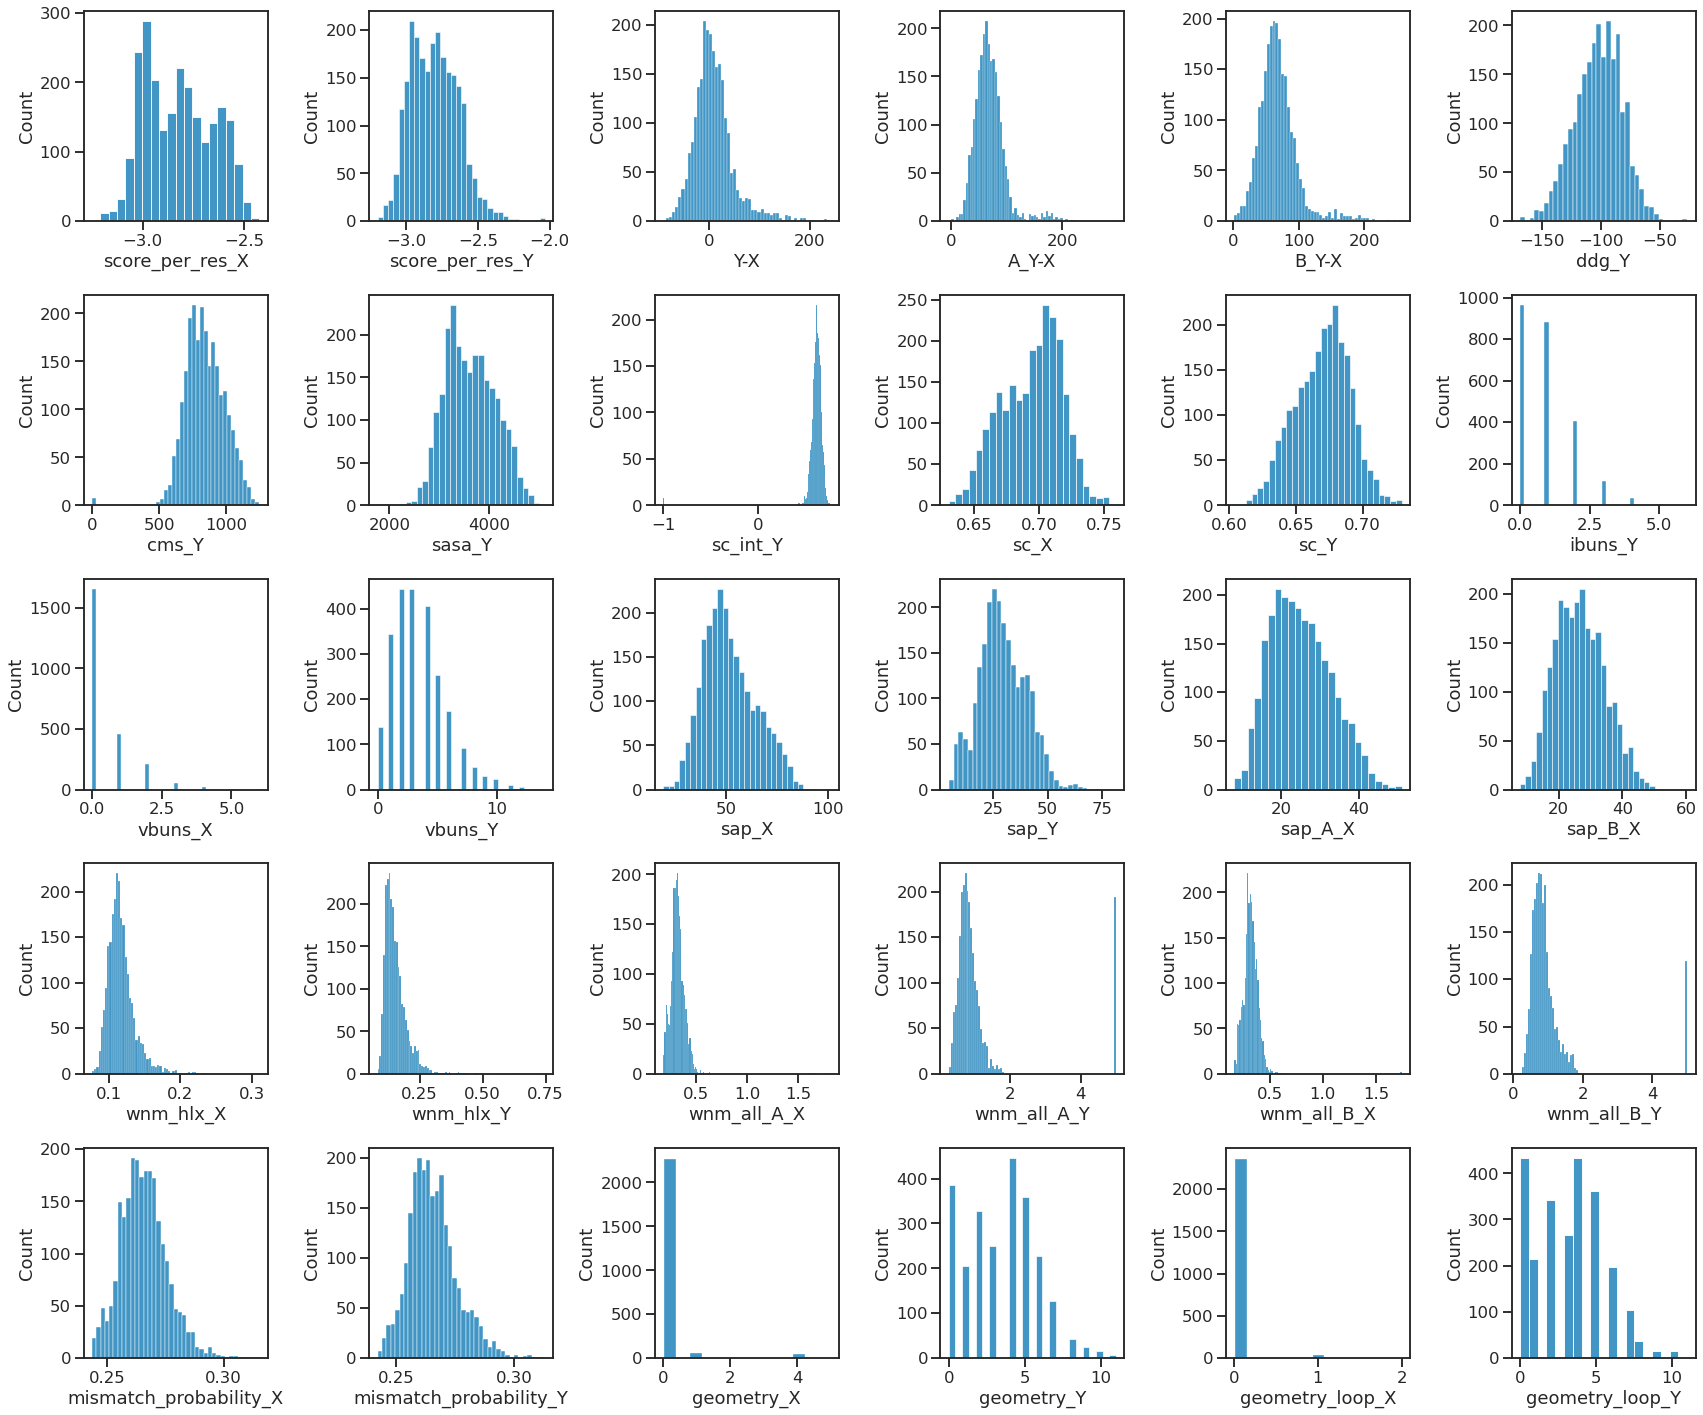

In [16]:
# Remove outliers

cutoffs = [('Y-X', 250, 0),
           ('sc_Y', 0.58, 1),
           ('score_per_res_Y', -2, 0)
]

no_outliers_df = filter_df(scores_df, cutoffs)
histplot_df(no_outliers_df)

In [17]:
# Filter designs- stringent global filter

cutoffs = [('Y-X', -20, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('sc_int_Y', 0.65, 1),
           ('wnm_hlx_X', 0.20, 0),
           ('wnm_hlx_Y', 0.20, 0),
           ('wnm_all_A_X', 1, 0),
           ('wnm_all_B_X', 1, 0),
           ('wnm_all_A_Y', 1, 0),
           ('wnm_all_B_Y', 1, 0),
           ('vbuns_X', 3, 0),
           ('vbuns_Y', 3, 0),
]

global_df = filter_df(scores_df, cutoffs)
print_scores(global_df)

14


,score_per_res_X,score_per_res_Y,Y-X,A_Y-X,B_Y-X,ddg_Y,cms_Y,sasa_Y,sc_int_Y,sc_X,sc_Y,ibuns_Y,vbuns_X,vbuns_Y,sap_X,sap_Y,sap_A_X,sap_B_X,wnm_hlx_X,wnm_hlx_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,mismatch_probability_X,mismatch_probability_Y,geometry_X,geometry_Y,geometry_loop_X,geometry_loop_Y,parent
05_two_state/run_1/decoys/0000/afc1931341877e4c7701992f09a80a294d0e6feee6f301c8.pdb,-2.771397,-2.870142,-35.547791,58.792969,23.957825,-96.891548,810.548096,3206.356445,0.682547,0.735235,0.708955,1,0,2,39.178894,23.694878,14.383818,24.795042,0.114832,0.143157,0.319367,0.638169,0.293630,0.805718,0.257442,0.257442,0,5,0,5,X22_3_16_4_ct4_fa
05_two_state/run_1/decoys/0000/df89d3e8e6efafd9568833edd06c8af61ae479ee4fc02b80.pdb,-2.995305,-3.084985,-40.894287,69.224243,36.880188,-123.719887,961.833435,3905.251465,0.650698,0.691836,0.673352,0,0,1,57.501797,24.720877,27.401634,30.100203,0.128019,0.158948,0.228034,0.795532,0.254228,0.830684,0.268934,0.266515,0,1,0,1,X28_2_25_2_ct2_fb
05_two_state/run_1/decoys/0000/65c42779124f2d00bc6cc110c444a547dedf10cc1d1bbde1.pdb,-2.825460,-2.941990,-40.086060,35.946655,42.962891,-96.212738,801.447388,3180.051270,0.656269,0.732878,0.714218,0,0,1,45.047714,26.843699,16.910566,28.137178,0.148800,0.144993,0.300147,0.439224,0.326826,0.944774,0.264226,0.262429,0,1,0,1,X20_3_18_2_ct13_fe
05_two_state/run_1/decoys/0001/d8cefb8ffdbc1c619295d7a389f731037586b945c2b407f5.pdb,-2.518727,-2.571273,-20.598022,44.585052,44.394714,-80.922295,698.376038,3195.922852,0.651707,0.653468,0.624296,0,1,2,32.965469,25.691420,19.486614,13.478848,0.101024,0.104436,0.290730,0.737739,0.325932,0.564098,0.274761,0.279133,0,7,0,5,X18_4_23_4_ct3_ff
05_two_state/run_1/decoys/0001/7a0db542e561807901ddb801333f22bc95401e4d902092e3.pdb,-2.745105,-2.856987,-38.487305,42.962250,46.488098,-108.915703,794.787659,3117.556641,0.682422,0.713779,0.697167,1,0,2,38.150303,6.502478,20.720634,17.429680,0.105871,0.122750,0.181623,0.923887,0.245022,0.514756,0.281397,0.280132,0,0,0,0,DHR62
05_two_state/run_1/decoys/0001/46b25e9d8a47ce787b25967579a5898e2f6ccc0cc7e18415.pdb,-2.933136,-3.034891,-35.817505,58.959625,34.180511,-104.821373,805.356445,3214.462891,0.668275,0.710952,0.670541,0,1,2,45.614475,8.254646,18.574194,27.040287,0.125217,0.110350,0.258478,0.570120,0.239226,0.307800,0.259315,0.259229,0,4,0,4,X19_3_18_4_ct4_fd
05_two_state/run_1/decoys/0001/9b712b50b023430be15a7767e71c2b43603aa0644cc06efd.pdb,-2.559227,-2.623907,-27.424683,24.844330,52.156494,-80.388428,678.513245,3240.203125,0.655393,0.652003,0.677285,1,1,1,55.853825,35.676117,30.149982,25.703787,0.118281,0.111406,0.373180,0.667203,0.364909,0.460005,0.259075,0.260458,0,0,0,0,X27_3_19_4_ct3_fe
05_two_state/run_1/decoys/0001/0f8049b9aa1169029a4d294a922913b9ba8e641accbff236.pdb,-2.739002,-2.854234,-42.405457,35.480804,56.727356,-117.508690,870.532715,3346.161865,0.677933,0.690805,0.667268,0,0,2,45.257252,26.831476,26.144781,19.112446,0.091025,0.097047,0.329125,0.554223,0.302695,0.855602,0.267207,0.267373,0,6,0,6,X19_4_19_4_ct5_fa
05_two_state/run_1/decoys/0001/7f83cefd3dd28dda7d292984b2523d34a453f392fa7f1edb.pdb,-2.811174,-2.883555,-26.057129,62.585663,43.860138,-110.365578,817.764954,3228.072998,0.658528,0.713266,0.697024,3,0,0,50.386456,28.078762,21.392590,28.993835,0.121084,0.117847,0.336688,0.745649,0.365557,0.939780,0.261636,0.263395,0,4,0,4,X22_3_16_4_ct4_fa
05_two_state/run_1/decoys/0001/573a2b60157b4bec89ae7e03f9956db708e81cebffa619bd.pdb,-2.696626,-2.771225,-33.420288,89.140991,57.924500,-130.766830,1160.062012,4565.737305,0.656158,0.671857,0.665254,2,0,2,65.850807,34.705860,32.962765,32.887970,0.123261,0.125324,0.317523,0.566540,0.324728,0.625435,0.270070,0.269838,0,2,0,2,DHR79


In [19]:
print(get_parents(global_df))

11
['X22_3_16_4_ct4_fa', 'X28_2_25_2_ct2_fb', 'X20_3_18_2_ct13_fe', 'X18_4_23_4_ct3_ff', 'DHR62', 'X19_3_18_4_ct4_fd', 'X27_3_19_4_ct3_fe', 'X19_4_19_4_ct5_fa', 'DHR79', 'X16_4_16_2_ct7_fe', 'X26_3_24_2_ct12_fe']


In [22]:
# Copy best designs to a folder

out_dir = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_1/global_filter/'
copy_designs(global_df, out_dir)

256


,score_per_res_X,score_per_res_Y,Y-X,A_Y-X,B_Y-X,ddg_Y,cms_Y,sasa_Y,sc_int_Y,sc_X,sc_Y,ibuns_Y,vbuns_X,vbuns_Y,sap_X,sap_Y,sap_A_X,sap_B_X,wnm_hlx_X,wnm_hlx_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,mismatch_probability_X,mismatch_probability_Y,geometry_X,geometry_Y,geometry_loop_X,geometry_loop_Y,parent
05_two_state/run_1/decoys/0000/afc1931341877e4c7701992f09a80a294d0e6feee6f301c8.pdb,-2.771397,-2.870142,-35.547791,58.792969,23.957825,-96.891548,810.548096,3206.356445,0.682547,0.735235,0.708955,1,0,2,39.178894,23.694878,14.383818,24.795042,0.114832,0.143157,0.319367,0.638169,0.293630,0.805718,0.257442,0.257442,0,5,0,5,X22_3_16_4_ct4_fa
05_two_state/run_1/decoys/0000/53a6653f5671821fc4868eaf9f25502eb5cb2dad84c44db3.pdb,-3.034823,-3.002280,11.455078,54.113342,91.790100,-116.671097,859.710876,3579.285156,0.648820,0.710199,0.687719,1,0,2,41.288887,9.910739,21.801233,19.487650,0.106703,0.140129,0.244507,0.950320,0.223354,0.546362,0.254096,0.250228,0,4,0,4,X19_3_18_4_ct4_fd
05_two_state/run_1/decoys/0000/ac68b93782680a01b0f2d1d7f696c181d63a57935b8134f0.pdb,-2.742600,-2.718419,8.318298,64.391724,52.053925,-81.433670,714.240784,2996.684570,0.708252,0.708331,0.679008,0,0,2,43.231136,18.414373,12.055620,31.175497,0.104739,0.106093,0.259107,0.715452,0.264547,0.695781,0.271722,0.268341,0,3,0,3,X23_2_15_3_ct5_fe
05_two_state/run_1/decoys/0000/bd72752a64db32c189a48b074e808fbbe770146dfbf5cd29.pdb,-3.071645,-3.010392,21.561157,67.255554,72.993774,-99.531937,784.038086,3215.520752,0.664489,0.708501,0.687967,0,0,1,52.259518,18.891285,22.141161,30.118330,0.106699,0.129053,0.206947,0.736530,0.452807,0.655542,0.260150,0.259851,0,2,0,2,X19_3_18_4_ct4_fd
05_two_state/run_1/decoys/0000/d6905e325cc1644fa77a2c489385f903670028b780c8f73f.pdb,-2.582736,-2.620087,-15.837036,49.609955,61.283752,-108.473335,885.976074,3708.743896,0.680338,0.634909,0.638914,1,0,1,46.624622,31.390921,26.176874,20.447748,0.119300,0.112946,0.343712,0.613232,0.332157,0.484280,0.258554,0.257956,0,0,0,0,X27_3_19_4_ct3_fe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
05_two_state/run_1/decoys/0002/fd50eff42057fff33ee39eb2bc0e91f764f733bda2089723.pdb,-2.743913,-2.583109,57.889526,159.208313,31.432800,-111.927643,786.374084,3137.882568,0.649725,0.721417,0.720275,1,0,4,60.153496,29.060867,30.645287,29.508175,0.129163,0.125952,0.285750,0.647944,0.303363,0.622022,0.256769,0.255898,0,6,0,6,X22_3_16_4_ct4_fa
05_two_state/run_1/decoys/0002/296f48931d1d31a1331f8382bf92beedf1dae2401c8ee589.pdb,-2.974332,-3.019153,-21.155396,50.211060,67.562622,-121.442421,880.220459,3730.566650,0.632579,0.715381,0.668315,0,0,4,60.261234,31.118702,29.103504,31.157656,0.128640,0.152918,0.341813,0.834260,0.276083,0.771022,0.264096,0.263174,0,2,0,2,X26_3_26_4_ct2_fe
05_two_state/run_1/decoys/0002/891f5a5319fb63a8dab703770bec00bf9200a097dff1bfc0.pdb,-2.866563,-2.872452,-2.355713,38.932129,85.157166,-109.975227,809.997375,3177.971924,0.684070,0.706221,0.688414,0,0,4,41.974041,26.258307,25.071796,16.902252,0.111023,0.113055,0.258699,0.640299,0.255904,0.788827,0.269971,0.268726,0,0,0,0,hDHR71_5CWN
05_two_state/run_1/decoys/0002/52212cffc6dafac8779fb80c704466c7db1c13b2919fbd84.pdb,-2.710355,-2.714616,-1.465576,72.331177,35.720093,-74.865181,666.788940,2914.504639,0.642942,0.703183,0.689098,1,0,3,39.479412,21.873163,13.180582,26.298855,0.090384,0.133031,0.284217,0.409734,0.311562,0.346377,0.270190,0.268824,0,4,0,4,X23_2_15_3_ct5_fe


42
['X22_3_16_4_ct4_fa', 'X19_3_18_4_ct4_fd', 'X23_2_15_3_ct5_fe', 'X27_3_19_4_ct3_fe', 'DHR79', 'hDHR64_5CWM', 'X26_3_20_2_ct1_fe', 'hDHR71_5CWN', 'X23_4_26_3_ct8_fc', 'X19_4_19_4_ct5_fa', 'X17_3_21_2_ct0_fd', 'X27_2_27_2_ct5_fg', 'X16_4_16_2_ct7_fe', 'X26_3_24_2_ct12_fe', 'X17_4_20_3_ct10_fb', 'DHR71', 'X28_2_25_2_ct2_fb', 'X22_4_20_3_ct0_ff', 'hDHR53_5CWK', 'DHR59', 'DHR82', 'X24_2_24_2_ct5_ff', 'DHR62', 'X19_3_19_3_ct11_fc', 'X17_4_21_2_ct3_fd', 'X19_3_17_2_ct9_fe', 'X24_2_24_2_ct18_fg', 'X20_3_18_2_ct13_fe', 'X16_4_15_3_ct0_fc', 'X18_4_22_4_ct0_ff', 'X16_3_18_4_ct6_fe', 'X18_4_23_4_ct3_ff', 'X19_4_18_2_ct6_fg', 'X20_3_18_2_ct6_fa', 'hDHR79_5CWP', 'X20_3_25_2_ct9_fa', 'X26_3_26_4_ct2_fe', 'X17_4_20_3_ct4_fa', 'X23_4_25_4_ct0_fa', 'X19_3_17_2_ct28_fe', 'X19_3_17_2_ct6_fc', 'X21_4_23_4_ct0_fg']


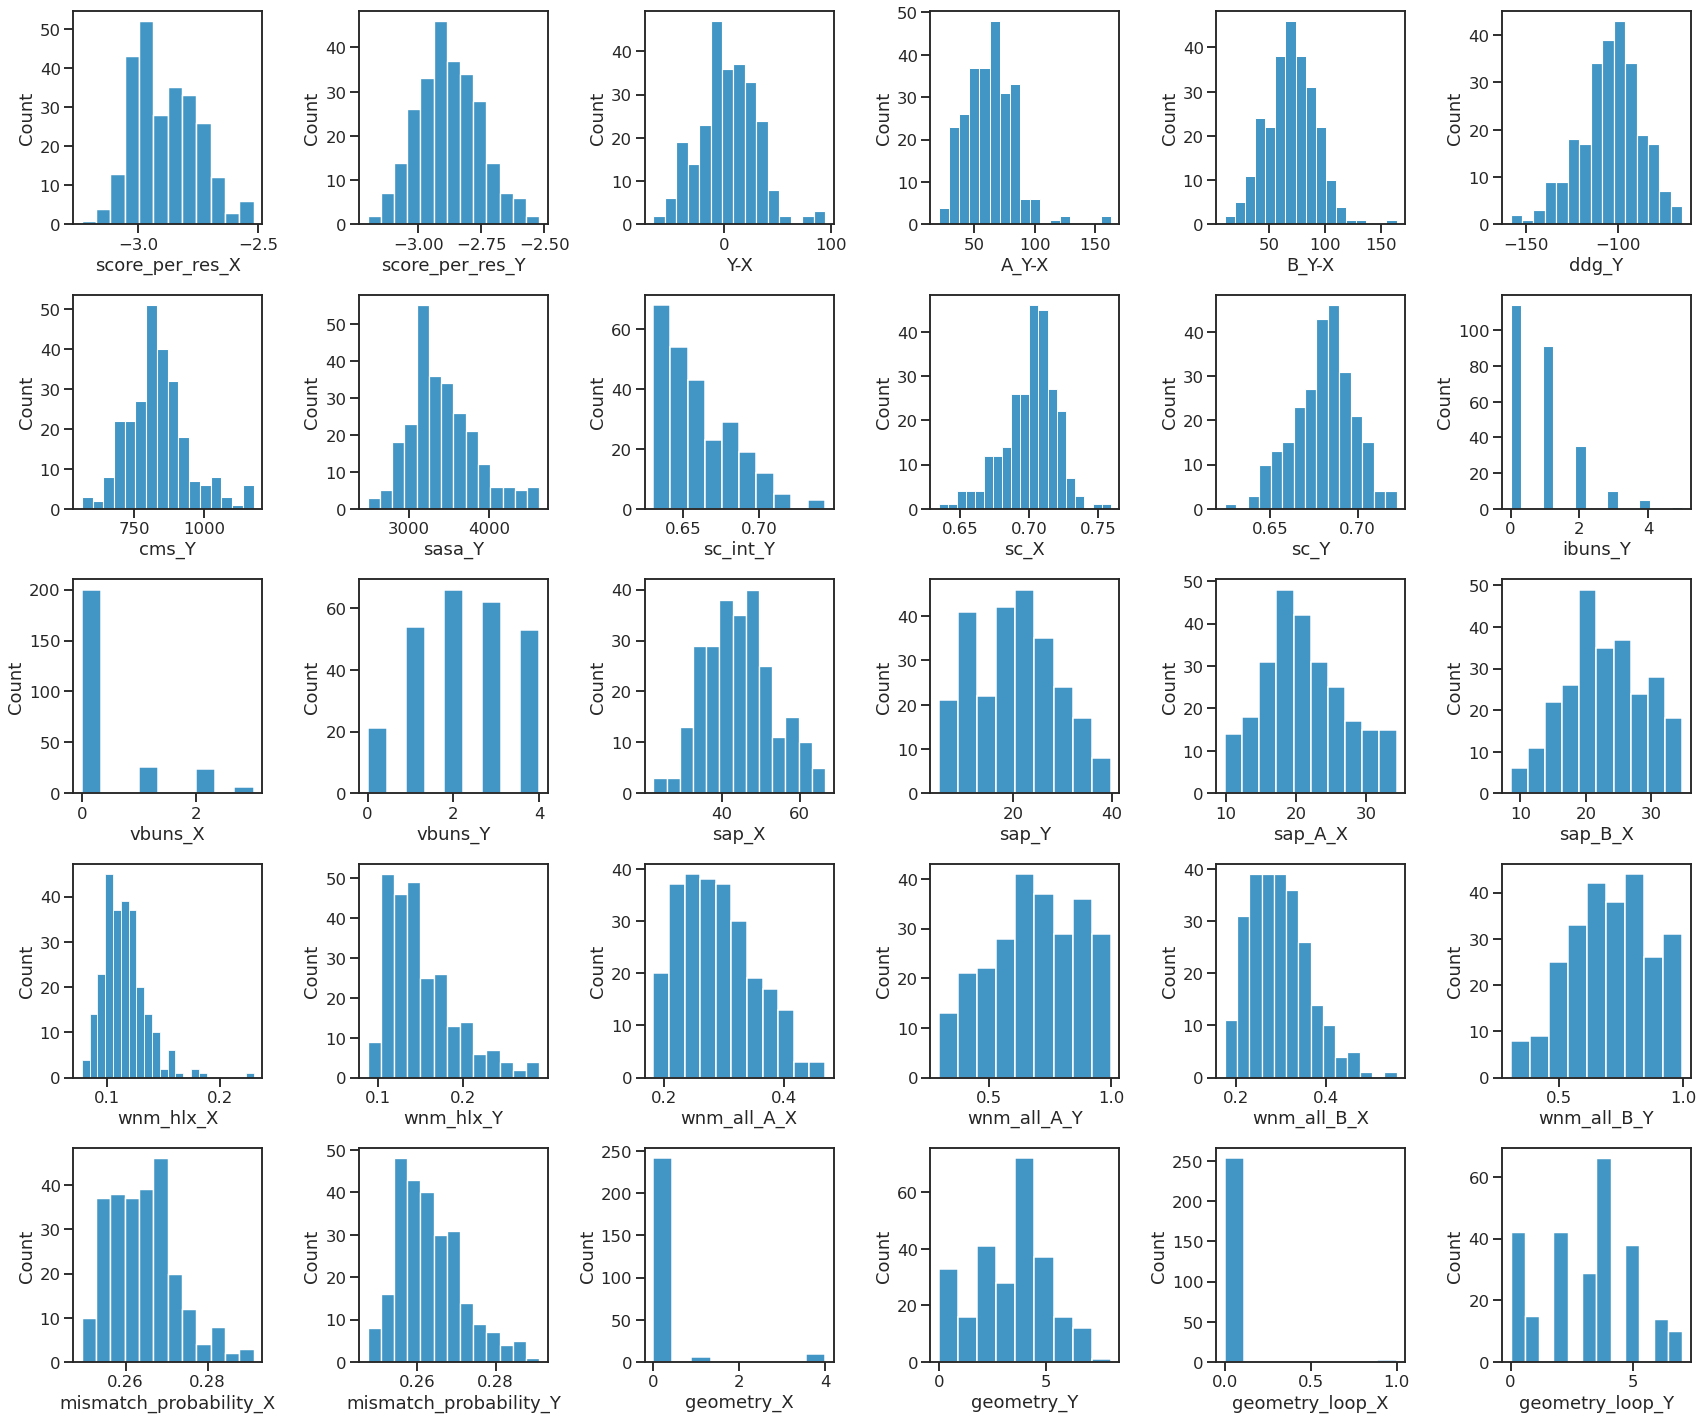

In [23]:
# Filter designs- very lenient, pre-delta filtering

cutoffs = [
        #    ('Y-X', -10, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('sc_int_Y', 0.63, 1),
           ('wnm_hlx_X', 0.4, 0),
           ('wnm_hlx_Y', 0.4, 0),
           ('wnm_all_A_X', 1, 0),
           ('wnm_all_B_X', 1, 0),
           ('wnm_all_A_Y', 1, 0),
           ('wnm_all_B_Y', 1, 0),
           ('vbuns_X', 4, 0),
           ('vbuns_Y', 5, 0),
]

pre_delta_df = filter_df(scores_df, cutoffs)
print_scores(pre_delta_df)
print(get_parents(pre_delta_df))
histplot_df(pre_delta_df)

In [24]:
def read_scorefile(scores):
    import pandas as pd

    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores

parent_path = os.path.join(os.getcwd(), "00_inputs")
parent_scores = os.path.join(parent_path, "scaffold_scores.json")
parent_df = read_scorefile(parent_scores)
parent_df.set_index('name', inplace=True) # replaces the indexing by path to indexing by name
parent_df.head()

,cms_dhr,dslf_fa13,fa_atr,fa_dun_dev,fa_dun_rot,fa_dun_semi,fa_elec,fa_intra_atr_xover4,fa_intra_elec,fa_intra_rep_xover4,...,score,score_1,score_12,score_2,score_per_res,ss_sc,total_score,wnm_1,wnm_2,wnm_hlx
name,,,,,,,,,,,,,,,,,,,,,
DHR79,465.784760,0.0,-1400.636238,20.246144,145.179909,274.889648,-579.788253,-75.762132,-46.974228,73.894970,...,-561.677002,-245.034546,-561.677002,-251.905350,-2.553077,0.698439,-561.676986,0.322625,0.316925,0.094490
DHR39,321.138519,0.0,-1021.834993,17.066784,143.013018,193.845212,-399.394071,-59.330212,-31.171610,63.490618,...,-385.315033,-170.901306,-385.315033,-169.123169,-2.335243,0.731973,-385.315035,0.377876,0.327590,0.085988
DHR82,521.558899,0.0,-1498.559091,21.318266,188.024945,262.872950,-583.674273,-79.204600,-40.859747,99.079365,...,-621.641541,-269.689850,-621.641541,-283.966553,-2.726498,0.744233,-621.641546,0.226993,0.237057,0.110452
DHR53,357.954865,0.0,-1060.006597,10.302994,129.002023,184.958473,-407.824125,-53.968461,-22.101187,61.719093,...,-457.311920,-204.453018,-457.311920,-195.076950,-2.722095,0.788842,-457.311918,0.384927,0.392240,0.087457
DHR54,401.634857,0.0,-1047.650966,13.488556,126.581043,188.660628,-426.607112,-60.735843,-40.887647,66.710380,...,-449.422302,-189.710556,-449.422302,-196.766571,-2.643661,0.702949,-449.422302,0.279068,0.318838,0.076508


4it [00:00, 27.30it/s]


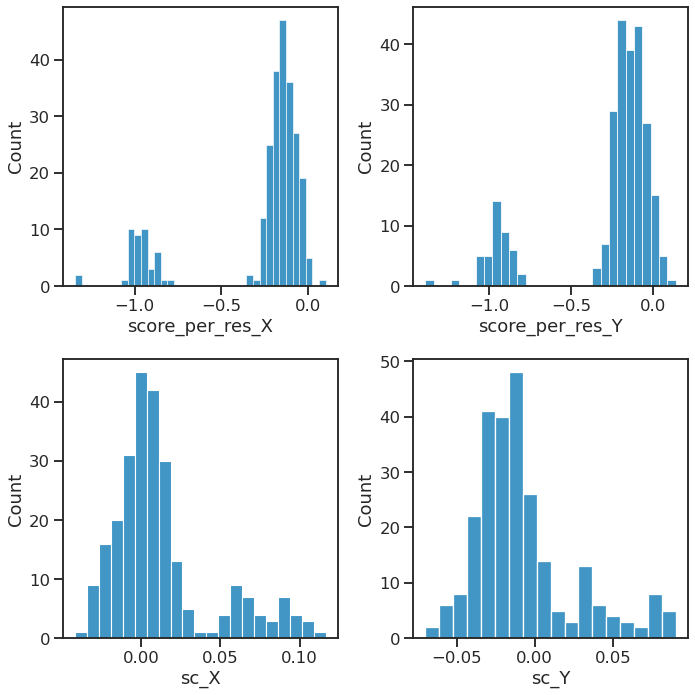

In [25]:
# Plots distributions of delta scores between the parent and the children.
# Delta scores are calculated by design_value - parent_value.
# For scores which I'm trying to maximize, higher delta values are better.
# Conclusion: all score_per_res are better than the parents, and sc and cms usually increase, even for the side domains!
# Only cms_dhr decreases significantly from the parent.
# So, let's just filter based on whether designs are as good as or better than the parent (cutoffs at 0).

delta_pairs = [('score_per_res_X', 'score_per_res'),
               ('score_per_res_Y', 'score_per_res'),
               ('sc_X', 'ss_sc'),
               ('sc_Y', 'ss_sc')]

score_terms, parent_terms = tuple(map(list, zip(*delta_pairs)))
# gets the columns to filter on from the parent df, then duplicate rows by parent such that rows correspond to the parents of the rows of filtered df
parent_aligned_df = parent_df[parent_terms].loc[pre_delta_df['parent'], :]
parent_aligned_df.index = pre_delta_df.index
parent_aligned_df.columns = score_terms # fixes an issue with duplicate column names, and makes sure the output columns are correctly named
delta_df = pre_delta_df[score_terms] - parent_aligned_df

fig, axs = plt.subplots(2, 2, figsize=(10,10))

for col, ax in tqdm(zip(score_terms, axs.flatten())):
    sns.histplot(
        data=delta_df,
        x=col,
        ax=ax,
#         kde=True
#         hue='parent'
        # bins=100
    )

plt.tight_layout()

159
26
['X19_3_18_4_ct4_fd', 'X23_2_15_3_ct5_fe', 'hDHR64_5CWM', 'X26_3_20_2_ct1_fe', 'hDHR71_5CWN', 'X23_4_26_3_ct8_fc', 'DHR71', 'X27_3_19_4_ct3_fe', 'hDHR53_5CWK', 'X26_3_24_2_ct12_fe', 'DHR59', 'X22_4_20_3_ct0_ff', 'X19_3_17_2_ct9_fe', 'X24_2_24_2_ct18_fg', 'X20_3_18_2_ct13_fe', 'X16_4_15_3_ct0_fc', 'X18_4_22_4_ct0_ff', 'X19_3_19_3_ct11_fc', 'X16_3_18_4_ct6_fe', 'X18_4_23_4_ct3_ff', 'X19_4_18_2_ct6_fg', 'hDHR79_5CWP', 'X20_3_25_2_ct9_fa', 'X22_3_16_4_ct4_fa', 'X28_2_25_2_ct2_fb', 'X21_4_23_4_ct0_fg']


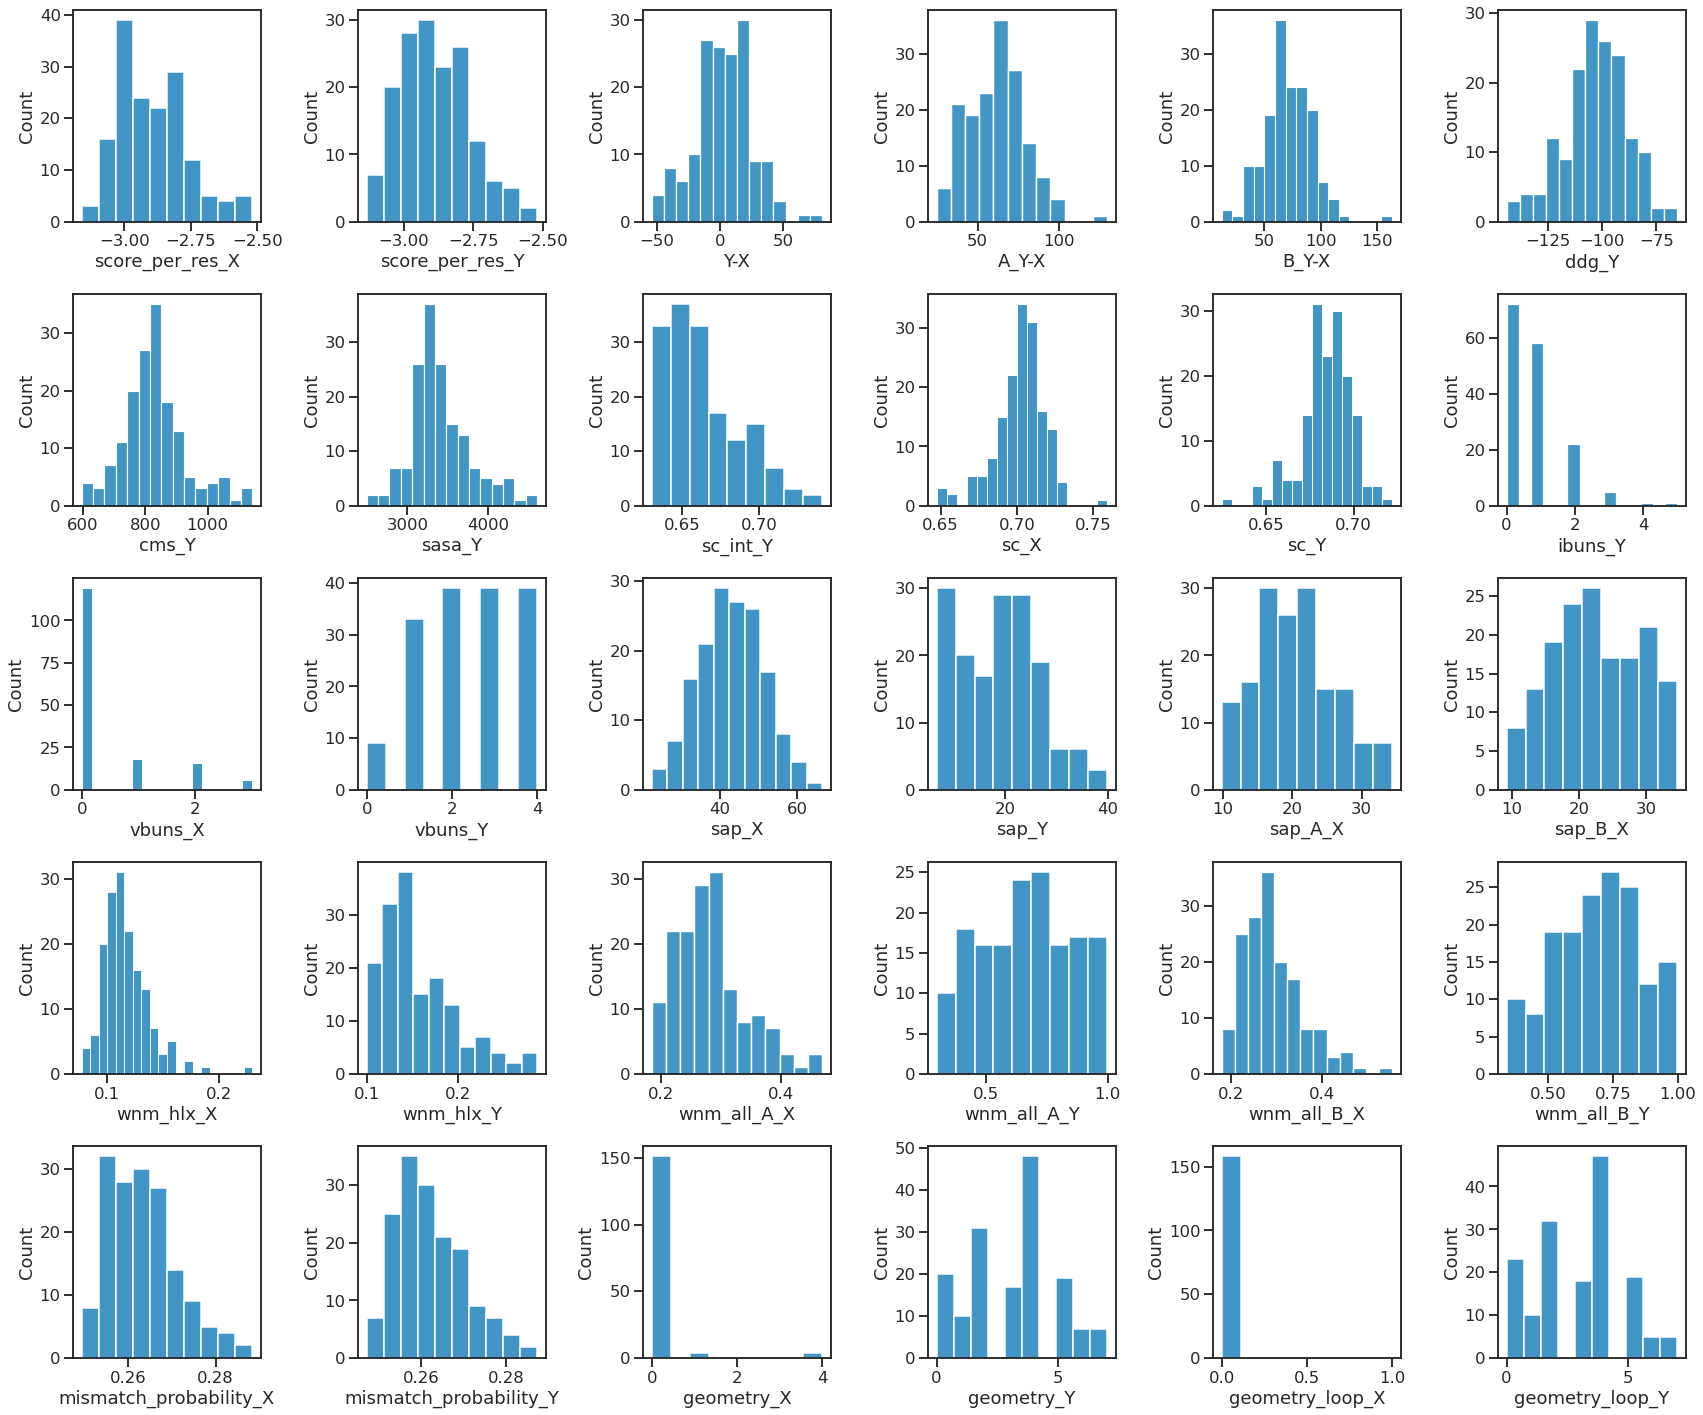

In [27]:
# how do I determine these cutoffs? Look at distributions of delta cutoffs between the parent and the children

# here, "cutoff" means "if the design scores worse than the parent by x"
delta_cutoffs = [('score_per_res_X', 'score_per_res', 0, 0),
                 ('score_per_res_Y', 'score_per_res', 0, 0),
                 ('sc_X', 'ss_sc', 0.015, 1),
                 ('sc_Y', 'ss_sc', 0.025, 1)]

delta_filtered_df = filter_df_delta(pre_delta_df, parent_df, delta_cutoffs)
print(get_parents(delta_filtered_df))
histplot_df(delta_filtered_df)

4it [00:00, 38.02it/s]


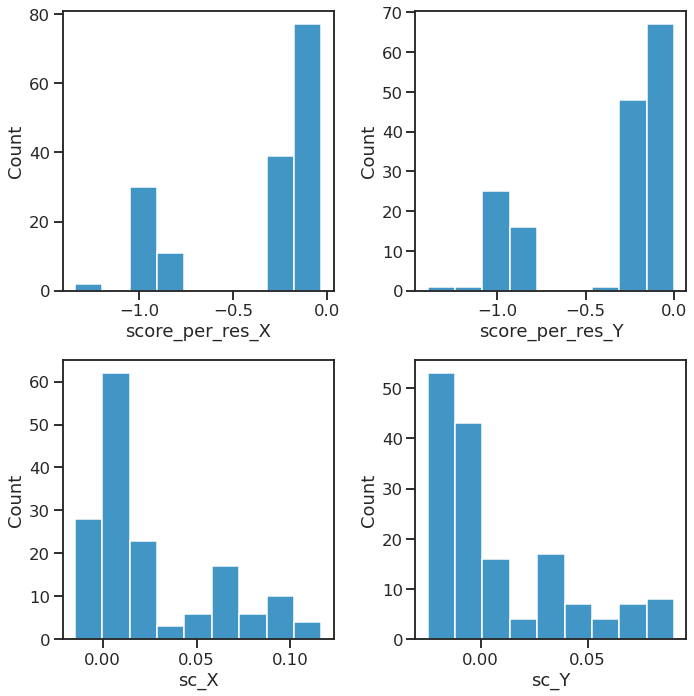

In [28]:
# Plots distributions of delta scores between the parent and the children.
# Delta scores are calculated by design_value - parent_value.
# For scores which I'm trying to maximize, higher delta values are better.
# Conclusion: all score_per_res are better than the parents, and sc and cms usually increase, even for the side domains!
# Only cms_dhr decreases significantly from the parent.
# So, let's just filter based on whether designs are as good as or better than the parent (cutoffs at 0).

delta_pairs = [('score_per_res_X', 'score_per_res'),
               ('score_per_res_Y', 'score_per_res'),
               ('sc_X', 'ss_sc'),
               ('sc_Y', 'ss_sc')]

score_terms, parent_terms = tuple(map(list, zip(*delta_pairs)))
# gets the columns to filter on from the parent df, then duplicate rows by parent such that rows correspond to the parents of the rows of filtered df
parent_aligned_df = parent_df[parent_terms].loc[delta_filtered_df['parent'], :]
parent_aligned_df.index = delta_filtered_df.index
parent_aligned_df.columns = score_terms # fixes an issue with duplicate column names, and makes sure the output columns are correctly named
delta_df = delta_filtered_df[score_terms] - parent_aligned_df

fig, axs = plt.subplots(2, 2, figsize=(10,10))

for col, ax in tqdm(zip(score_terms, axs.flatten())):
    sns.histplot(
        data=delta_df,
        x=col,
        ax=ax,
#         kde=True
#         hue='parent'
        # bins=100
    )

plt.tight_layout()

In [7]:
# Generate list to alphafold

cutoffs = [('Y-X', 100, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('vbuns_X', 4, 0),
           ('vbuns_Y', 5, 0),
]

af_df = filter_df(scores_df, cutoffs)

with open('05_two_state/run_1/des_selected.list', 'w') as f:
    for index, row in af_df.iterrows():
        f.write(index + '\n')

1242


In [8]:
def add2silent( tag, pose, sfd_out, filename ):

    struct = sfd_out.create_SilentStructOP()
    struct.fill_struct( pose, tag )
    sfd_out.add_structure( struct )
    sfd_out.write_silent_struct( struct, filename )

pyrosetta.distributed.maybe_init(**{
    "options": "-corrections::beta_nov16 true",
    "extra_options":{
        "-out:level": "100"
}})

In [10]:
# Save pdbs with only the dimer for alphafolding

silent_filename = "05_two_state/run_1/dimers_selected_for_af2.silent"
sfd_out = pyrosetta.rosetta.core.io.silent.SilentFileData( silent_filename, False, False, "binary", pyrosetta.rosetta.core.io.silent.SilentFileOptions())

keep_dimer = pyrosetta.rosetta.protocols.simple_moves.SwitchChainOrderMover()
keep_dimer.chain_order("34")

with open('05_two_state/run_1/des_selected.list', 'r') as sel_f:
    for line in sel_f:
        pdb_file = line.rstrip()
        tag = pdb_file.split('/')[-1][:-4]
        pose = pyrosetta.pose_from_pdb(pdb_file)
        keep_dimer.apply(pose)
        add2silent(tag, pose, sfd_out, silent_filename)